In [30]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import requests
import StringIO
import re
import pandas as pd

print __version__

init_notebook_mode(connected=True)

1.12.6


In [16]:
import seaborn as sns
%matplotlib inline

In [13]:
df = pd.read_csv('kp_all_movies.csv')

## Зависимость оценки от популярности (количества оценок)

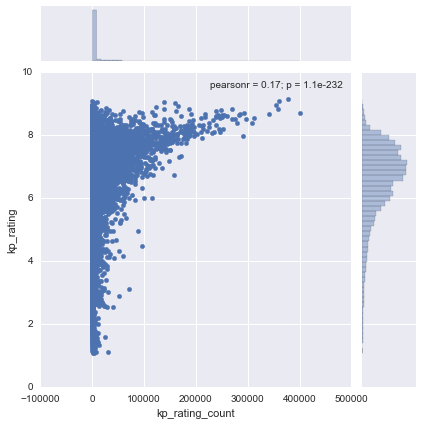

In [19]:
sns.jointplot(data = df, y = 'kp_rating', x = 'kp_rating_count')

In [79]:
sdf = df[['kp_rating', 'kp_rating_count']].copy()
sdf['count'] = 1
total = sdf['count'].sum()
sdf['kp_rating_rounded'] = map(lambda x: round(x, 1), sdf.kp_rating)
sdf['kp_rating_count_rounded'] = map(lambda x: round(x, -2), sdf.kp_rating_count)

In [80]:
z_data = sdf.pivot_table(index = 'kp_rating_rounded', columns = 'kp_rating_count_rounded',
               values = 'count', aggfunc = sum)
z_data = z_data.applymap(lambda x: float(x)/total)

In [82]:
surf = go.Surface(z = z_data.as_matrix(), x = z_data.index.values, y = z_data.columns)
iplot([surf])

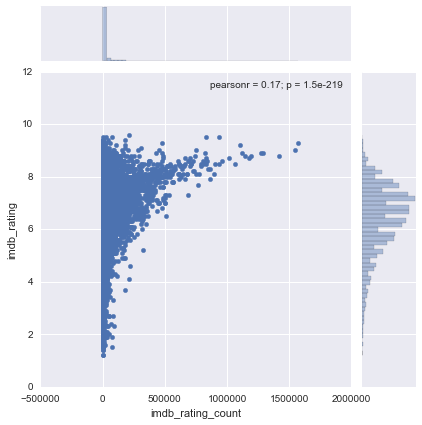

In [20]:
sns.jointplot(data = df, y = 'imdb_rating', x = 'imdb_rating_count')

## Зависимость рейтинга от бюджета

In [47]:
money_df = df[['name_rus', 'kp_rating', 'imdb_rating', 'budget', 'movie_year']]
money_df.dropna(inplace = True)

money_df = money_df[map(lambda x: '$' in x, money_df.budget)]
money_df['money'] = map(lambda x: int(re.sub('[^0-9]', '', x)), money_df.budget)

/Users/miptgirl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



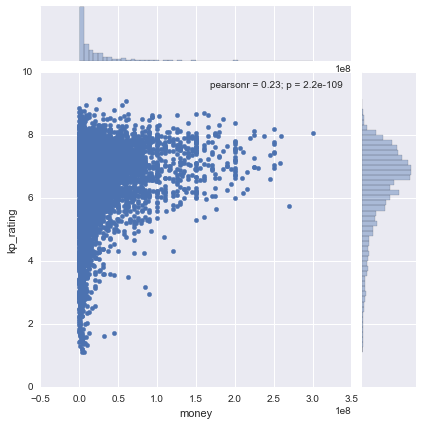

In [41]:
sns.jointplot(data = money_df, x = 'money', y = 'kp_rating')

In [55]:
df.head()

,movie_id,name_rus,kp_rating,movie_duration,kp_rating_count,movie_year,imdb_rating,imdb_rating_count,genres,countries,budget,critics_rating,name_eng
0,10000,Иезавель,7.411,104,518.0,1938,7.6,8585.0,"[драма, мелодрама]",[США],$1 250 000,94.0,Jezebel
1,100049,47 ронинов,7.660,204,297.0,1962,7.8,1496.0,"[боевик, драма, история]",[Япония],NaN,NaN,Chûshingura
2,10005,Живем один раз,7.168,86,330.0,1937,7.4,3812.0,"[фильм-нуар, драма, криминал]",[США],$575 000,100.0,You Only Live Once
3,100053,Колдун 2,7.745,113,109.0,2003,6.5,393.0,"[фэнтези, боевик]",[Япония],NaN,NaN,Onmyoji 2
4,100096,"Ильза, тигрица из Сибири",4.286,85,151.0,1977,4.9,1211.0,[ужасы],[Канада],CAD 250 000,NaN,Ilsa the Tigress of Siberia


In [60]:
count_year_df = df.groupby('movie_year', as_index = False).movie_id.count()

In [61]:
trace = go.Scatter(
    x = count_year_df.movie_year,
    y = count_year_df.movie_id,
    mode = 'lines'
)

iplot([trace])

In [65]:
rating_year_df = df.groupby('movie_year', as_index = False)[['kp_rating', 'imdb_rating']].mean()
trace_kp = go.Scatter(
    x = rating_year_df.movie_year,
    y = rating_year_df.kp_rating,
    mode = 'lines',
    name = u'КиноПоиск'
)
trace_imdb = go.Scatter(
    x = rating_year_df.movie_year,
    y = rating_year_df.imdb_rating,
    mode = 'lines',
    name = 'IMDb'
)

iplot([trace_kp, trace_imdb])

In [67]:
rating_count_year_df = df.groupby('movie_year', as_index = False)[['kp_rating_count', 'imdb_rating_count']].mean()
trace_kp = go.Scatter(
    x = rating_count_year_df.movie_year,
    y = rating_count_year_df.kp_rating_count,
    mode = 'lines',
    name = u'КиноПоиск'
)
trace_imdb = go.Scatter(
    x = rating_count_year_df.movie_year,
    y = rating_count_year_df.imdb_rating_count,
    mode = 'lines',
    name = 'IMDb'
)

iplot([trace_kp, trace_imdb])

## Жанры

In [99]:
df['genres'] = df['genres'].fillna('[]')

In [105]:
lst_str = u'[драма, мелодрама]'



[u'\u0434\u0440\u0430\u043c\u0430',
 u'\u043c\u0435\u043b\u043e\u0434\u0440\u0430\u043c\u0430']

In [120]:
def parse_list(lst_str):
    return filter(lambda y: y != '', 
                  map(lambda x: x.strip(), 
                      lst_str.replace('[', '').replace(']', '').split(',')))

In [125]:
import numpy as np
genres_data = []
for record in df.to_dict(orient = 'records'):
    genres_lst = parse_list(record['genres'])
    for genre in genres_lst:
        copy = record.copy()
        copy['genre'] = genre
        copy['weight'] = 1./len(genres_lst)
        genres_data.append(copy)

In [126]:
genres_df = pd.DataFrame.from_dict(genres_data)

In [131]:
top_genres = genres_df.groupby('genre')[['movie_id']].count()\
    .sort_values('movie_id', ascending = False)\
    .head(10).index.values.tolist()

In [142]:
N = float(len(top_genres))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]
data = [{
    'y': genres_df[genres_df.genre == top_genres[i]].kp_rating, 
    'type':'box',
    'marker':{'color': c[i]},
    'name': top_genres[i]
    } for i in range(len(top_genres))]

iplot(data)

## Распределение жанров по годам

In [148]:
genres_df['genre_group'] = map(lambda x: x if x in top_genres else 'другое', genres_df.genre)

In [199]:
N = float(len(top_genres) + 1)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

In [220]:
items_list = []
N = int(N)
items_list.append(
    dict(
        args=['visible', [True] + [False]*N],
        label=u'все',
        method='restyle'
    )
)
for i in range(len(top_genres)):
    items_list.append(
        dict(
            args=['visible', [False]*(i+1) + [True] + [False]*(N-1-i)],
            label= top_genres[i],
            method='restyle'
        )
    )

In [222]:
data = []
total = genres_df.groupby('movie_year').movie_id.nunique()
trace = go.Bar(
        x = total.index.values,
        y = total.values,
        name = u'Всего',
        marker = {'color': c[0]}
    )

data.append(trace)
for i in range(len(top_genres)):
    genre = top_genres[i]
    tmp_df = genres_df[genres_df.genre_group == genre].groupby('movie_year').movie_id.nunique()
    trace = go.Bar(
        x = tmp_df.index.values,
        y = tmp_df.values,
        name = genre,
        marker = {'color': c[i+1]},
        visible = False
    )
    data.append(trace)

layout = go.Layout(
    title='Фильмы по жанрам',
    updatemenus=list([
        dict(
            x=-0.1,
            y=1,
            yanchor='top',
            buttons=items_list
        )
    ]),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [156]:
genres_share_df = genres_df.pivot_table(index = 'movie_year', values = 'weight',
                     aggfunc = sum, columns = 'genre_group').fillna(0)
genres_share_df = genres_share_df.apply(lambda x: x/genres_share_df.sum(axis = 1))

In [160]:
data = []
for genre in genres_df.genre_group.unique():
    trace = go.Bar(
        x = genres_share_df.index.values,
        y = genres_share_df[genre].values,
        name = genre
    )
    data.append(trace)

layout = go.Layout(
    barmode='stack'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [163]:
genres_coincidents = {}

In [169]:
from collections import defaultdict
for item in df.genres:
    parsed_genres = parse_list(item)
    for genre1 in parsed_genres:
        if genre1 not in genres_coincidents:
            genres_coincidents[genre1] = defaultdict(int)
        for genre2 in parsed_genres:
            genres_coincidents[genre1][genre2] += 1

In [175]:
genres_coincidents_df = pd.DataFrame.from_dict(genres_coincidents).fillna(0)

In [176]:
heatmap = go.Heatmap(
    z = genres_coincidents_df.values,
    x = genres_coincidents_df.index.values,
    y = genres_coincidents_df.columns
)

iplot([heatmap])

In [182]:
genres_coincidents_df_norm = genres_coincidents_df.apply(lambda x: x/genres_df.groupby('genre').movie_id.count())

In [183]:
heatmap = go.Heatmap(
    z = genres_coincidents_df_norm.values,
    x = genres_coincidents_df_norm.index.values,
    y = genres_coincidents_df_norm.columns
)

iplot([heatmap])